# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
## For store type create dummy variables, but for assortment level do numerical encoding (1,2,3)

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
store_data = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail Sales Prediction/Rossmann Stores Data.csv')
stores = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail Sales Prediction/store.csv')

In [6]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
#store_data['StateHoliday'].unique()
#store_data['StateHoliday'] = store_data['StateHoliday'].map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'})
## Convert date column from object to date


In [8]:
## Convert the Date column to Datetime
store_data['Date']= pd.to_datetime(store_data['Date'])

## Extract Year and month from Date column
store_data['Year'] = pd.DatetimeIndex(store_data['Date']).year
store_data['Month'] = pd.DatetimeIndex(store_data['Date']).month

In [9]:
## Displaying the data
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


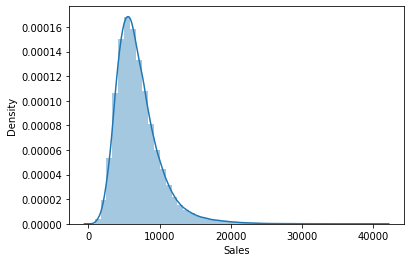

In [10]:
sns.distplot(store_data[store_data['Sales']!=0]['Sales']);

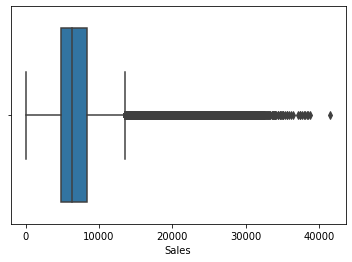

In [11]:
sns.boxplot(store_data[store_data['Sales']!=0]['Sales']);

In [12]:
store_data_high_sales=store_data[store_data['Sales']>=20000][['Year','Month','Sales']]

In [13]:
## See count of high sales/day in certain months to estimate high sales period
pd.pivot_table(data=store_data_high_sales[['Year','Month','Sales']],index='Month',columns='Year',aggfunc='count',fill_value=0)

Sales          
Year   2013 2014 2015
Month                
1        79   78   75
2        86   96   75
3       169  104  124
4       108  148  151
5       130  123  132
6        88  173  186
7       137   83  123
8        97   76    0
9        74   89    0
10       93   73    0
11      111  120    0
12      532  367    0

In [14]:
## Check total sales monthwise
Sales_across_years_monthwise=pd.pivot_table(data=store_data[['Year','Month','Sales']],index='Month',columns='Year',aggfunc='sum',fill_value=0)


In [15]:
Sales_across_years_monthwise['diff21']=Sales_across_years_monthwise[('Sales', 2014)]-Sales_across_years_monthwise[('Sales', 2013)]
Sales_across_years_monthwise['diff32']=Sales_across_years_monthwise[('Sales', 2015)]-Sales_across_years_monthwise[('Sales', 2014)]
Sales_across_years_monthwise['diff31']=Sales_across_years_monthwise[('Sales', 2015)]-Sales_across_years_monthwise[('Sales', 2013)]

In [16]:
Sales_across_years_monthwise

Sales                          diff21     diff32     diff31
Year        2013       2014       2015                                
Month                                                                 
1      180132207  187752787  198843730   7620580   11090943   18711523
2      171534275  178924677  178275458   7390402    -649219    6741183
3      201180369  193019854  205631683  -8160515   12611829    4451314
4      183431432  194544977  197918886  11113545    3373909   14487454
5      185411063  194693257  189143897   9282194   -5549360    3732834
6      180702351  190047051  207363373   9344700   17316322   26661022
7      208843882  173892707  212322616 -34951175   38429909    3478734
8      198042727  163748475          0 -34294252 -163748475 -198042727
9      178053963  164516168          0 -13537795 -164516168 -178053963
10     187662330  164216398          0 -23445932 -164216398 -187662330
11     196170924  173327953          0 -22842971 -173327953 -196170924
12     231710561  202120592          0 -29589969 -202120592 -231710561

In [17]:
#df_date_sorted_agg=
df_date_sorted_agg=store_data.copy().sort_values(['Date']).groupby('Date')['Sales'].sum()
df_date_sorted_agg

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

In [18]:
# ## Trying to get a series for plotting agg sales day wise, check any pattern to add varibale like seasonality
# df=df_date_sorted_agg.reset_index()
# df['Sales']=(df['Sales']-df['Sales'].min())/(df['Sales'].max()-df['Sales'].min())
# df.head()

In [19]:
#Sales_year_month['Year'].unique()

In [20]:
#### Do we observe any pattern in sales across years, ## No

In [21]:
#sns.barplot(data=Sales_year_month[Sales_year_month['Year']==2013],x='Month',y='Sales_x')

In [22]:
#sns.barplot(data=Sales_year_month[Sales_year_month['Year']==2014],x='Month',y='Sales_x')

In [23]:
#sns.barplot(data=Sales_year_month[Sales_year_month['Year']==2015],x='Month',y='Sales_x')

In [24]:
#sns.barplot(data=df_test.groupby(['DayOfWeek'])['Sales_x'].sum().reset_index(),x='DayOfWeek',y='Sales_x')  ## Starts with Monday

In [25]:
## Just to check promo interval values and corresponding Promo2SinceWeek
#stores[stores['PromoInterval']!=0].head()

In [26]:
stores.shape

(1115, 10)

In [27]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [28]:
stores[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna())].shape

(544, 10)

In [29]:
stores[stores['CompetitionOpenSinceMonth'].isna()]['Store'].nunique()

354

In [30]:
## Wherever Promo2 ie continuing and consecutive promotion is zero, implies store didn't participate,
# hence Promo2SinceWeek and Promo2SinceYear should be zero, also there won't be PromoInterval
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna()),['Promo2SinceWeek']]=0
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceYear'].isna()),['Promo2SinceYear','PromoInterval']]=0

In [31]:
#Impute CompetitionDistance with max distance

stores.loc[stores['CompetitionDistance'].isna()]=stores['CompetitionDistance'].max()

In [32]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    351
CompetitionOpenSinceYear     351
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [33]:
#stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].describe()

In [34]:
## Check the CompetitionOpenSinceYear year range
stores['CompetitionOpenSinceYear'].describe()

count      764.000000
mean      2298.660995
std       4621.710349
min       1900.000000
25%       2006.000000
50%       2010.000000
75%       2013.000000
max      75860.000000
Name: CompetitionOpenSinceYear, dtype: float64

In [35]:
#stores[~stores['CompetitionOpenSinceYear'].isin([1900,1961])]['CompetitionOpenSinceYear'].min()

In [36]:
## This is the day since when we have the sales data
store_data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [37]:
stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].min()

2009.0

In [38]:
### Not req now, 
## Equivalent code has been written in below cell
### Ref https://www.kaggle.com/shivam017arora/rossmann-sales-prediction-top-1-solution

# competition_open = []
# for index, value in stores[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
#     try:
#         year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
#         date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
#         competition_open.append(date)
#     except:
#         competition_open.append('1813-01-01') # Added a dummy date, 200 yrs less than min sales date
# stores['CompetitionOpen'] = pd.Series(competition_open)
# stores['CompetitionOpen'] = stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
# stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])
# #stores['CompetitionOpen']=stores['CompetitionOpen'].map(int)
# #stores['CompetitionOpen']=stores['CompetitionOpen'].apply(lambda x:x if x!='2021-10-30' else 0)




# promo = []
# for index, value in stores[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
#     try:
#         year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
#         date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
#         promo.append(date)
#     except:
#         promo.append('1909-01-01')   ## dummy date
# stores['promoYearWeek'] = pd.to_datetime(pd.Series(promo))
# stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
# stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])
#stores.loc[stores['promoYearWeek'].isna(),'promoYearWeek'] =0# stores['promoYearWeek'].dt.strftime('%Y%m%d')
#stores['promoYearWeek']=stores['promoYearWeek'].map(int)

In [39]:
#### calculate difference in number of days for competion and promo
## Function to change data format
def competition_open_yr_mnth(cols):
  try:
    year, month = int(cols[0]), int(cols[1])
    date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
    return date
  except:
    return '1813-01-01'  ## Dummy date to identify this data and do transformation afterwards

stores['CompetitionOpen']=stores[['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']].apply(competition_open_yr_mnth,axis=1)
stores['CompetitionOpen']= stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])




def promo_yr_wk(cols):
  try:
    year, week = int(cols[1]), int(cols[0])
    date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
    return date
  except:
    return '1909-01-01' ## dummy date


stores['promoYearWeek'] =stores[['Promo2SinceWeek', 'Promo2SinceYear']].apply(promo_yr_wk,axis=1)
stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])

In [40]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,1909-01-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,1909-01-01
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,1909-01-01


In [41]:
# ## Not req

# ## Merge part
# date_test=pd.merge(store_data,stores,on='Store')
# date_test['day_diff_comp']=(date_test['Date']-date_test['CompetitionOpen']).dt.days
# date_test['day_diff_promo']=(date_test['Date']-date_test['promoYearWeek']).dt.days
# date_test.loc[date_test['day_diff_comp']>=73000,'day_diff_comp']=0
# date_test.loc[date_test['day_diff_promo']>=36500,'day_diff_promo']=0

In [42]:
# ## Not req

# date_test[date_test['promoYearWeek']=='1909-01-01'].shape

In [43]:
# ## Not req

# date_test[date_test['CompetitionOpen']=='1813-01-01'].shape   #(323348, 22)
# #date_test['day_diff']
# date_test[date_test['day_diff']>=73000].shape

In [44]:
# ### Not req

# date_test[(date_test['Promo2SinceWeek']==0) & (date_test['Promo2SinceYear']==0)].shape

In [45]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   StoreType                  1115 non-null   object        
 2   Assortment                 1115 non-null   object        
 3   CompetitionDistance        1115 non-null   float64       
 4   CompetitionOpenSinceMonth  764 non-null    float64       
 5   CompetitionOpenSinceYear   764 non-null    float64       
 6   Promo2                     1115 non-null   int64         
 7   Promo2SinceWeek            1115 non-null   float64       
 8   Promo2SinceYear            1115 non-null   float64       
 9   PromoInterval              1115 non-null   object        
 10  CompetitionOpen            1115 non-null   datetime64[ns]
 11  promoYearWeek              1115 non-null   datetime64[ns]
dtypes: dat

In [46]:
#stores['CompetitionOpen'].astype(int).describe()

In [47]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,1909-01-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,1909-01-01
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,1909-01-01


In [48]:
## Check the CompetitionOpenSinceMonth values
#stores['CompetitionOpenSinceMonth'].describe() ## 1 to 12
#stores[stores['CompetitionOpenSinceMonth']<=3]

In [49]:
#stores[stores['CompetitionOpenSinceYear']==1900]

In [50]:
## For interval, will think afterwards
#join_with = stores['PromoInterval'].str.split(',').apply(pd.Series)
#join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')

In [51]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 85.4+ MB


In [52]:
store_data_merged=pd.merge(store_data,stores,on='Store')

In [53]:
## Calculate the number of days since when the promo started
store_data_merged['day_diff_comp']=(store_data_merged['Date']-store_data_merged['CompetitionOpen']).dt.days
store_data_merged['day_diff_promo']=(store_data_merged['Date']-store_data_merged['promoYearWeek']).dt.days

## Identifying the data based on teh dummy dates and changing them to zero
store_data_merged.loc[store_data_merged['day_diff_comp']>=73000,'day_diff_comp']=0
store_data_merged.loc[store_data_merged['day_diff_promo']>=36500,'day_diff_promo']=0

In [54]:
## Sort data in ascending order of date
store_data_merged=store_data_merged.sort_values(['Date']).reset_index()

In [55]:
store_data_merged.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek,day_diff_comp,day_diff_promo
0,1014566,1115,2,2013-01-01,0,0,0,0,a,1,2013,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1813-01-01,2012-06-03,0,212
1,458921,504,2,2013-01-01,0,0,0,0,a,1,2013,1,c,c,820.0,NaN,NaN,0,0.0,0.0,0,1813-01-01,1909-01-01,0,0
2,924068,1016,2,2013-01-01,0,0,0,0,a,1,2013,1,c,c,550.0,NaN,NaN,1,35.0,2010.0,"Mar,Jun,Sept,Dec",1813-01-01,2010-09-05,0,849
3,220625,243,2,2013-01-01,0,0,0,0,a,1,2013,1,a,a,310.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",1813-01-01,2013-02-10,0,-40
4,2825,3,2,2013-01-01,0,0,0,0,a,1,2013,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10,2223,632


In [56]:
## Get index of data for last year from March to test
store_data_merged[(store_data_merged['Year']==2015) & (store_data_merged['Month']>=3)].head(2) ## 844431

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek,day_diff_comp,day_diff_promo
844431,1094,2,7,2015-03-01,0,0,0,0,0,0,2015,3,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04,2677,1792
844432,507160,558,7,2015-03-01,0,0,0,0,0,0,2015,3,a,a,3000.0,2.0,2010.0,0,0.0,0.0,0,2010-02-01,1909-01-01,1854,0


In [57]:
170136/len(store_data_merged) ## 16 % of data to test

0.16769321296671388

In [58]:
store_data_merged.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionOpen', 'promoYearWeek',
       'day_diff_comp', 'day_diff_promo'],
      dtype='object')

In [59]:
store_data_merged.drop(columns=['index','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpen','promoYearWeek'],inplace=True)

In [60]:
#store_data.drop(columns='Date',inplace=True)
store_data_merged.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo
0,1115,2,0,0,0,0,a,1,2013,1,d,c,5350.0,1,0,212
1,504,2,0,0,0,0,a,1,2013,1,c,c,820.0,0,0,0
2,1016,2,0,0,0,0,a,1,2013,1,c,c,550.0,1,0,849
3,243,2,0,0,0,0,a,1,2013,1,a,a,310.0,1,0,-40
4,3,2,0,0,0,0,a,1,2013,1,a,a,14130.0,1,2223,632


In [61]:
store_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014567 entries, 0 to 1014566
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1014567 non-null  int64  
 1   DayOfWeek            1014567 non-null  int64  
 2   Sales                1014567 non-null  int64  
 3   Customers            1014567 non-null  int64  
 4   Open                 1014567 non-null  int64  
 5   Promo                1014567 non-null  int64  
 6   StateHoliday         1014567 non-null  object 
 7   SchoolHoliday        1014567 non-null  int64  
 8   Year                 1014567 non-null  int64  
 9   Month                1014567 non-null  int64  
 10  StoreType            1014567 non-null  object 
 11  Assortment           1014567 non-null  object 
 12  CompetitionDistance  1014567 non-null  float64
 13  Promo2               1014567 non-null  int64  
 14  day_diff_comp        1014567 non-null  int64  
 15

In [62]:
## Convert datatype of CompetitionDistance from 
store_data_merged['CompetitionDistance']=store_data_merged['CompetitionDistance'].astype(int)

In [63]:
## Encoding Assortment with numerical values
store_data_merged['Assortment']=store_data_merged['Assortment'].apply(lambda x: 1 if x=='a' else (2 if x=='b' else 3))

In [64]:
## Create Dummy variables for object type data
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [65]:
## Check presence of null in data
store_data_final.isna().sum().sum()


0

In [66]:
############ Final Data store_data_final

In [67]:
## Import libraries for Lin Reg
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [68]:
## Divide data into train and test
## Index based split to test sales for last few months instead of selecting randomly from dataset
store_data_train=store_data_final.iloc[0:844431]
store_data_test=store_data_final.iloc[844431:]

In [69]:
store_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844431 entries, 0 to 844430
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Store                844431 non-null  int64
 1   DayOfWeek            844431 non-null  int64
 2   Sales                844431 non-null  int64
 3   Customers            844431 non-null  int64
 4   Open                 844431 non-null  int64
 5   Promo                844431 non-null  int64
 6   SchoolHoliday        844431 non-null  int64
 7   Year                 844431 non-null  int64
 8   Month                844431 non-null  int64
 9   Assortment           844431 non-null  int64
 10  CompetitionDistance  844431 non-null  int64
 11  Promo2               844431 non-null  int64
 12  day_diff_comp        844431 non-null  int64
 13  day_diff_promo       844431 non-null  int64
 14  StateHoliday_0       844431 non-null  uint8
 15  StateHoliday_a       844431 non-null  uint8
 16  St

In [70]:
## Separating the target variable from both train and test dataset and converting the dataframe into numpy array.
X_train=store_data_train.drop('Sales',axis=1).to_numpy()
y_train=store_data_train['Sales'].to_numpy()

X_test=store_data_test.drop('Sales',axis=1).to_numpy()
y_test=store_data_test['Sales'].to_numpy()

In [71]:
## Standardisation of data so that it can be used for regression model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
## Using the paarmeters from Standard scaler to transform test dataset
X_test = scaler.transform(X_test)

In [72]:
## Test using a simple regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

## fit_intercept=False increases the mse value, so fitting the intercept

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
print(regressor.intercept_)
reg_coeff=list(regressor.coef_)
print(reg_coeff)

5744.562405927788
[-31.113566322243198, -91.81665542652036, 3363.7189288720515, 313.75099821730777, 532.6478225882972, 8.37836543748814, 58.43175774102239, 93.87375663651095, 114.94225966407173, 156.66289090306645, 51.23958457044431, 24.37114657613878, 87.51967273555034, 52.08548683910408, -56.555296144907665, -40.19459922829313, -10.518521584931504, -648.3731216611625, -42.87492306651234, 420.7394050485927]


In [74]:
# Predict the Train data using model parameters
y_pred_train = regressor.predict(X_train)

In [75]:
# Predict the Test data
y_pred = regressor.predict(X_test)

In [76]:
mean_squared_error(y_test, y_pred) ##1690521.112153421

1690521.112153421

In [77]:
# Train data performance
print("Mean Square error for training dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_train, y_pred_train))))
# Test data performance
print("Mean Square error for test dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_test, y_pred))))

Mean Square error for training dataset: 1231.21
Mean Square error for test dataset: 1300.20


In [78]:
## calculate R-square Score for train dataset
print("R2 Score for train dataset: {:.4f}".format(r2_score(y_train, y_pred_train)))

R2 Score for train dataset: 0.8968


In [79]:
## calculate R-square Score for test dataset
r2=r2_score(y_test, y_pred)
print("R2 Score for test dataset: {:.4f}".format(r2))
## Adjusted R square
r2_adj=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R-square value for test dataset : {:.4f}".format(r2_adj))

R2 Score for test dataset: 0.8910
Adjusted R-square value for test dataset : 0.8910


In [80]:
linreg_scores=list([r2,r2_adj])

In [81]:
# Looking at the Test and predicted data side by side
#pd.DataFrame({'Test': y_test, 'Pred': y_pred})


In [82]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

In [83]:
lm = LinearRegression()
# create a KFold object with 5 splits 
folds = KFold(n_splits = 7, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
for i,j in enumerate(scores):
  print("R-square value after {} iteration: {:.4f}".format(i+1,j))


R-square value after 1 iteration: 0.8952
R-square value after 2 iteration: 0.8969
R-square value after 3 iteration: 0.8979
R-square value after 4 iteration: 0.8988
R-square value after 5 iteration: 0.8976
R-square value after 6 iteration: 0.8954
R-square value after 7 iteration: 0.8958


In [84]:
## We put the KFold with RFE, with number of features as hyper parameter to find optimal no of features and corresponding R-square 
# Define a cross-validation parameters
folds = KFold(n_splits = 5, shuffle = True, random_state = 150)

# Specify range of number of parameters to tune
hyper_params = [{'n_features_to_select': list(range(10, 20))}]


# Perform grid search using Linear regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)
rfe = RFE(regressor)             

model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model.fit(X_train, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=150, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [85]:
# Crossvalidation results
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.472506,0.052987,0.024715,0.002265,10,{'n_features_to_select': 10},0.896521,0.895942,0.894302,0.895546,0.896715,0.895805,0.000858,10,0.895630,0.895776,0.896186,0.895875,0.895583,0.895810,0.000215
1,4.253170,0.038208,0.026435,0.004745,11,{'n_features_to_select': 11},0.896755,0.896171,0.894513,0.895780,0.896918,0.896028,0.000860,9,0.895850,0.895997,0.896412,0.896095,0.895810,0.896033,0.000215
2,3.947826,0.025248,0.025908,0.002294,12,{'n_features_to_select': 12},0.896962,0.896387,0.894689,0.895937,0.897156,0.896226,0.000881,8,0.896047,0.896192,0.896617,0.896304,0.896000,0.896232,0.000220
3,3.630182,0.022996,0.023843,0.000637,13,{'n_features_to_select': 13},0.897072,0.896486,0.894802,0.896045,0.897271,0.896335,0.000880,7,0.896156,0.896304,0.896725,0.896414,0.896107,0.896341,0.000220
4,3.261685,0.013901,0.028882,0.003143,14,{'n_features_to_select': 14},0.897173,0.896624,0.894957,0.896181,0.897393,0.896466,0.000865,6,0.896294,0.896433,0.896849,0.896543,0.896240,0.896472,0.000216
5,2.890611,0.020158,0.028059,0.003506,15,{'n_features_to_select': 15},0.897297,0.896756,0.895063,0.896300,0.897510,0.896585,0.000871,5,0.896413,0.896549,0.896972,0.896663,0.896361,0.896591,0.000218
6,2.508195,0.033098,0.028571,0.003292,16,{'n_features_to_select': 16},0.897384,0.896851,0.895161,0.896390,0.897599,0.896677,0.000867,4,0.896506,0.896640,0.897063,0.896755,0.896453,0.896684,0.000217
7,2.073604,0.025709,0.030946,0.005368,17,{'n_features_to_select': 17},0.897465,0.896906,0.895220,0.896464,0.897657,0.896743,0.000870,3,0.896568,0.896709,0.897130,0.896819,0.896521,0.896749,0.000218
8,1.621388,0.011109,0.030144,0.004278,18,{'n_features_to_select': 18},0.897510,0.896953,0.895264,0.896501,0.897682,0.896782,0.000866,2,0.896606,0.896746,0.897169,0.896859,0.896564,0.896789,0.000217
9,1.143297,0.009487,0.030913,0.002920,19,{'n_features_to_select': 19},0.897515,0.896956,0.895272,0.896507,0.897687,0.896787,0.000865,1,0.896612,0.896753,0.897174,0.896865,0.896570,0.896794,0.000217


*It can be observed that not only the mean fit time is least for all the features but also the R-square value is highest.*

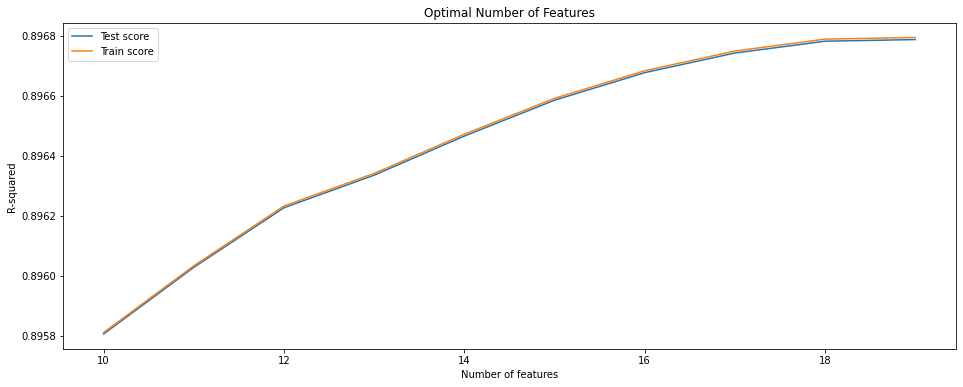

In [86]:
# Plotting results obtained from cross validation
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Number of features')
plt.ylabel('R-squared')
plt.title("Optimal Number of Features")
plt.legend(['Test score', 'Train score'], loc='upper left')

R-square seems to doesn't change much with almost half number of features, but we will proceed with all features as the fit time is least and also we can analyze with a different model.

In [87]:
# Final model based on all features
n_features_optimal = 19

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# Predict sales of test data
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)


## calculate R-square Score for Test dataset
print("R2 Score for test dataset with optimal features: {:.4f}".format(r2))

R2 Score for test dataset with optimal features: 0.8910


Now we test our data using regularized regression models

In [88]:
### Using regularized regression methods

In [89]:
## Import libraries
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

In [90]:
lasso = Lasso()
parameters = {'alpha': [1e-4,1e-3,1e-2,0.05,0.1,1,5,10,20,30,40,50,100,150]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=3)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 5, 10, 20,
                                   30, 40, 50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [91]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("Using ",lasso_regressor.best_params_, " the R-square value is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}
Using  {'alpha': 1}  the R-square value is:  0.8957295125196826


Here, we are iterating over a set of alphas to find the optimal parameter that gives the best R-square value. Since we get alpha as 1 we are not fitting the data again alpha=1 as it implies Linear regression only. There is no 

In [92]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
r2_lasso=r2_score(y_test, y_pred_lasso)
print("R-square value for test data using Lasso regression is {:.3f}".format(r2_lasso))

R-square value for test data using Lasso regression is 0.891


In [93]:
r2_adj_lasso=1-(1-r2_lasso)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

In [94]:
lassoreg_scores=list([r2_lasso,r2_adj_lasso])

In [95]:
lasso_coeff=list(lasso.coef_)
print(lasso_coeff)

[-30.164854634547986, -91.025736504562, 3361.8593172570427, 315.2258192815111, 532.2629704510347, 7.135552434451139, 56.95775841911718, 92.67936364070287, 114.19153106455892, 155.66645040652057, 49.981310373303046, 23.341214267457374, 87.41660994870944, 51.27404552727264, -55.58922633487068, -39.10542627491771, -9.28717704413616, -646.9502449860485, -41.98829512596169, 420.14252214262564]


In [96]:
# Hyperprarameter tuning
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,70,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 30,
                                   40, 70, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [97]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("Using ",ridge_regressor.best_params_, " the R-square value is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 100}
Using  {'alpha': 100}  the R-square value is:  0.8957217181207241


In [98]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print("R-square value for test data using ridge regression is {:.3f}".format(r2_score(y_test, y_pred_ridge)))

R-square value for test data using ridge regression is 0.891


In [99]:
ridge_coeff=list(ridge.coef_)

In [100]:
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_adj_ridge=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("R2 :" ,r2)
print("Adjusted R2 : ",r2_adj_ridge)

R2 : 0.8909644222555592
Adjusted R2 :  0.8909516032122362


In [101]:
ridgereg_scores=list([r2_ridge,r2_adj_ridge])

In [102]:
df_coeff=pd.DataFrame({'Lin Reg Coeff':reg_coeff,'Lasso Reg Coeff':lasso_coeff,'Ridge Reg Coeff':ridge_coeff},index=store_data_train.drop('Sales',axis=1).columns)


In [103]:
df_coeff

,Lin Reg Coeff,Lasso Reg Coeff,Ridge Reg Coeff
Store,-31.113566,-30.164855,-31.097813
DayOfWeek,-91.816655,-91.025737,-91.911631
Customers,3363.718929,3361.859317,3362.802111
Open,313.750998,315.225819,314.172406
Promo,532.647823,532.262970,532.711963
SchoolHoliday,8.378365,7.135552,8.384552
Year,58.431758,56.957758,58.428228
Month,93.873757,92.679364,93.894261
Assortment,114.942260,114.191531,115.000640
CompetitionDistance,156.662891,155.666450,156.570530


Final comparison of coefficients obtained from different models

In [104]:
pd.DataFrame({'Linear Regr':linreg_scores,'Lasso Regr':lassoreg_scores,'Ridge Regr':ridgereg_scores},index=['R2 Score','Adj R2 Score'])

,Linear Regr,Lasso Regr,Ridge Regr
R2 Score,0.890964,0.890880,0.890961
Adj R2 Score,0.890952,0.890867,0.890952


In [105]:
################################

In [106]:
store_data_merged['DayOfWeek']=store_data_merged['DayOfWeek'].astype(object)

In [107]:
store_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014567 entries, 0 to 1014566
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Store                1014567 non-null  int64 
 1   DayOfWeek            1014567 non-null  object
 2   Sales                1014567 non-null  int64 
 3   Customers            1014567 non-null  int64 
 4   Open                 1014567 non-null  int64 
 5   Promo                1014567 non-null  int64 
 6   StateHoliday         1014567 non-null  object
 7   SchoolHoliday        1014567 non-null  int64 
 8   Year                 1014567 non-null  int64 
 9   Month                1014567 non-null  int64 
 10  StoreType            1014567 non-null  object
 11  Assortment           1014567 non-null  int64 
 12  CompetitionDistance  1014567 non-null  int64 
 13  Promo2               1014567 non-null  int64 
 14  day_diff_comp        1014567 non-null  int64 
 15  day_diff_promo 

In [108]:
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [109]:
## Divide data into train and test
## Index based split to test sales for last few months instead of selecting randomly from dataset
store_data_train=store_data_final.iloc[0:844431]
store_data_test=store_data_final.iloc[844431:]

In [110]:
## Separating the target variable from both train and test dataset and converting the dataframe into numpy array.
X_train=store_data_train.drop(['Sales','Store'],axis=1).to_numpy()
y_train=store_data_train['Sales'].to_numpy()

X_test=store_data_test.drop(['Sales','Store'],axis=1).to_numpy()
y_test=store_data_test['Sales'].to_numpy()

In [111]:
## Standardisation of data so that it can be used for regression model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
## Using the paarmeters from Standard scaler to transform test dataset
X_test = scaler.transform(X_test)

In [112]:
## Test using a simple regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

## fit_intercept=False increases the mse value, so fitting the intercept

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [113]:
print(regressor.intercept_)
reg_coeff=list(regressor.coef_)
print(reg_coeff)

5744.562405927787
[3343.297450954396, 405.2066037627117, 595.4503957798231, 37.95759343415692, 56.48294383837949, 87.86783103879742, 115.88000811610472, 154.46480618437707, 47.450531891870476, 24.445704928649043, 88.80396764023938, -169.9996210977667, -219.12766963623707, -241.68526882287063, -191.44600298299616, -74.28451811119527, -103.91160473718796, 54.09396206398207, -13.719321075599858, -38.932216949475844, 18.153901335936254, -646.1215969379066, -44.27699529042478, 418.74727977293537]


In [114]:
# Predict the Train data using model parameters
y_pred_train = regressor.predict(X_train)

In [115]:
# Predict the Test data
y_pred = regressor.predict(X_test)

In [116]:
mean_squared_error(y_test, y_pred) ##1690521.112153421

1638269.4081673103

In [117]:
# Train data performance
print("Mean Square error for training dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_train, y_pred_train))))
# Test data performance
print("Mean Square error for test dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_test, y_pred))))

Mean Square error for training dataset: 1213.92
Mean Square error for test dataset: 1279.95


In [118]:
## calculate R-square Score for train dataset
print("R2 Score for train dataset: {:.4f}".format(r2_score(y_train, y_pred_train)))

R2 Score for train dataset: 0.8997


In [119]:
## calculate R-square Score for test dataset
r2=r2_score(y_test, y_pred)
print("R2 Score for test dataset: {:.4f}".format(r2))
## Adjusted R square
r2_adj=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R-square value for test dataset : {:.4f}".format(r2_adj))

R2 Score for test dataset: 0.8943
Adjusted R-square value for test dataset : 0.8943


In [120]:
linreg_scores=list([r2,r2_adj])

In [121]:
# Looking at the Test and predicted data side by side
#pd.DataFrame({'Test': y_test, 'Pred': y_pred})


In [122]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

In [123]:
lm = LinearRegression()
# create a KFold object with 5 splits 
folds = KFold(n_splits = 7, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
for i,j in enumerate(scores):
  print("R-square value after {} iteration: {:.4f}".format(i+1,j))


R-square value after 1 iteration: 0.8983
R-square value after 2 iteration: 0.8997
R-square value after 3 iteration: 0.9005
R-square value after 4 iteration: 0.9017
R-square value after 5 iteration: 0.9004
R-square value after 6 iteration: 0.8985
R-square value after 7 iteration: 0.8986


In [124]:
## We put the KFold with RFE, with number of features as hyper parameter to find optimal no of features and corresponding R-square 
# Define a cross-validation parameters
folds = KFold(n_splits = 5, shuffle = True, random_state = 150)

# Specify range of number of parameters to tune
hyper_params = [{'n_features_to_select': list(range(18, 26))}]


# Perform grid search using Linear regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)
rfe = RFE(regressor)             

model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=150, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [18, 19, 20, 21, 22, 23, 24,
                                                   25]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [125]:
# Crossvalidation results
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.343362,0.027558,0.035839,0.003018,18,{'n_features_to_select': 18},0.899985,0.899360,0.897929,0.899161,0.900144,0.899316,0.000785,8,0.899156,0.899313,0.899671,0.899363,0.899117,0.899324,0.000196
1,3.839719,0.028224,0.036811,0.004043,19,{'n_features_to_select': 19},0.900108,0.899490,0.898030,0.899276,0.900265,0.899434,0.000793,7,0.899273,0.899429,0.899793,0.899482,0.899235,0.899442,0.000198
2,3.293981,0.019658,0.036498,0.002760,20,{'n_features_to_select': 20},0.900189,0.899581,0.898116,0.899345,0.900345,0.899515,0.000792,6,0.899355,0.899508,0.899874,0.899567,0.899316,0.899524,0.000198
3,2.734086,0.027887,0.036308,0.003250,21,{'n_features_to_select': 21},0.900272,0.899667,0.898186,0.899426,0.900421,0.899594,0.000795,5,0.899433,0.899585,0.899955,0.899646,0.899397,0.899603,0.000199
4,2.127235,0.015225,0.036800,0.004241,22,{'n_features_to_select': 22},0.900296,0.899714,0.898232,0.899460,0.900445,0.899630,0.000787,4,0.899465,0.899623,0.899994,0.899687,0.899440,0.899642,0.000199
5,1.470308,0.009903,0.040802,0.003168,23,{'n_features_to_select': 23},0.900342,0.899745,0.898268,0.899488,0.900478,0.899664,0.000789,3,0.899503,0.899654,0.900023,0.899718,0.899470,0.899674,0.000197
6,0.790497,0.007044,0.038033,0.004418,24,{'n_features_to_select': 24},0.900345,0.899752,0.898268,0.899495,0.900476,0.899667,0.000789,1,0.899507,0.899656,0.900027,0.899720,0.899475,0.899677,0.000197
7,0.804516,0.007982,0.038343,0.002710,25,{'n_features_to_select': 25},0.900345,0.899752,0.898268,0.899495,0.900476,0.899667,0.000789,1,0.899507,0.899656,0.900027,0.899720,0.899475,0.899677,0.000197


*It can be observed that not only the mean fit time is least for all the features but also the R-square value is highest.*

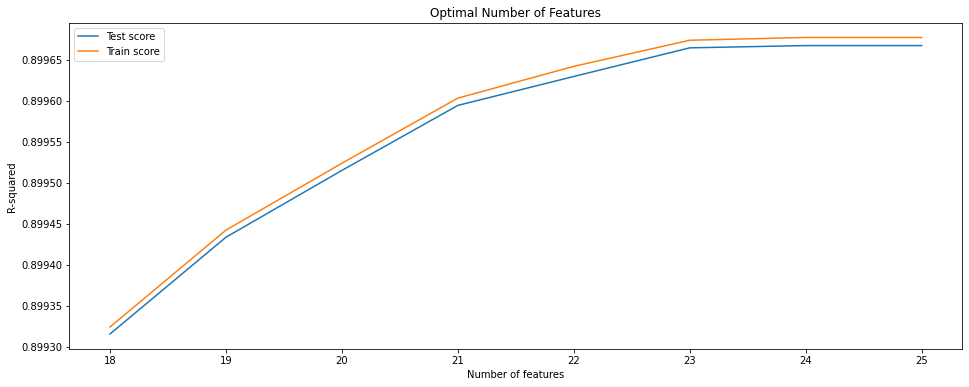

In [126]:
# Plotting results obtained from cross validation
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Number of features')
plt.ylabel('R-squared')
plt.title("Optimal Number of Features")
plt.legend(['Test score', 'Train score'], loc='upper left')

R-square seems to doesn't change much with almost half number of features, but we will proceed with all features as the fit time is least and also we can analyze with a different model.

In [127]:
# Final model based on all features
n_features_optimal = 25

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# Predict sales of test data
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)


## calculate R-square Score for Test dataset
print("R2 Score for test dataset with optimal features: {:.4f}".format(r2))

R2 Score for test dataset with optimal features: 0.8943


Now we test our data using regularized regression models

In [128]:
### Using regularized regression methods

In [129]:
## Import libraries
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

In [130]:
lasso = Lasso()
parameters = {'alpha': [1e-4,1e-3,1e-2,0.05,0.1,1,5,10,20,30,40,50,100,150]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=3)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 5, 10, 20,
                                   30, 40, 50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [131]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("Using ",lasso_regressor.best_params_, " the R-square value is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}
Using  {'alpha': 1}  the R-square value is:  0.8983461718229698


Here, we are iterating over a set of alphas to find the optimal parameter that gives the best R-square value. Since we get alpha as 1 we are not fitting the data again alpha=1 as it implies Linear regression only. There is no 

In [132]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
r2_lasso=r2_score(y_test, y_pred_lasso)
print("R-square value for test data using Lasso regression is {:.3f}".format(r2_lasso))

R-square value for test data using Lasso regression is 0.894


In [133]:
r2_adj_lasso=1-(1-r2_lasso)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

In [134]:
lassoreg_scores=list([r2_lasso,r2_adj_lasso])

In [135]:
lasso_coeff=list(lasso.coef_)
print(lasso_coeff)

[3341.968311949277, 415.43548182838623, 595.396950607361, 37.17920558183487, 54.95257676028202, 86.95011295112393, 115.09467592673735, 153.41027009753182, 46.28472668545873, 23.426388761867383, 88.680074954736, -163.6984002917434, -212.8386884896, -235.46960549957163, -185.23425638587213, -68.23771407904134, -89.2826874640922, 52.876800931637774, -9.755378414502662, -35.82698895976792, 18.71638704061493, -645.3181065618024, -43.329811872550025, 418.21091678847085]


In [136]:
# Hyperprarameter tuning
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,70,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 30,
                                   40, 70, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [137]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("Using ",ridge_regressor.best_params_, " the R-square value is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 100}
Using  {'alpha': 100}  the R-square value is:  0.8983333281641926


In [138]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print("R-square value for test data using ridge regression is {:.3f}".format(r2_score(y_test, y_pred_ridge)))

R-square value for test data using ridge regression is 0.894


In [139]:
ridge_coeff=list(ridge.coef_)

In [140]:
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_adj_ridge=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("R2 :" ,r2)
print("Adjusted R2 : ",r2_adj_ridge)

R2 : 0.8943345633861834
Adjusted R2 :  0.8943196556466562


In [141]:
ridgereg_scores=list([r2_ridge,r2_adj_ridge])

In [142]:
df_coeff=pd.DataFrame({'Lin Reg Coeff':reg_coeff,'Lasso Reg Coeff':lasso_coeff,'Ridge Reg Coeff':ridge_coeff},index=store_data_train.drop(['Sales','Store'],axis=1).columns)


In [143]:
df_coeff

,Lin Reg Coeff,Lasso Reg Coeff,Ridge Reg Coeff
Customers,3343.297451,3341.968312,3342.421594
Open,405.206604,415.435482,404.851784
Promo,595.450396,595.396951,595.492138
SchoolHoliday,37.957593,37.179206,37.954846
Year,56.482944,54.952577,56.479233
Month,87.867831,86.950113,87.893193
Assortment,115.880008,115.094676,115.937216
CompetitionDistance,154.464806,153.410270,154.384150
Promo2,47.450532,46.284727,47.342093
day_diff_comp,24.445705,23.426389,24.436373


Final comparison of coefficients obtained from different models

In [144]:
pd.DataFrame({'Linear Regr':linreg_scores,'Lasso Regr':lassoreg_scores,'Ridge Regr':ridgereg_scores},index=['R2 Score','Adj R2 Score'])

,Linear Regr,Lasso Regr,Ridge Regr
R2 Score,0.894335,0.894230,0.89433
Adj R2 Score,0.894320,0.894215,0.89432


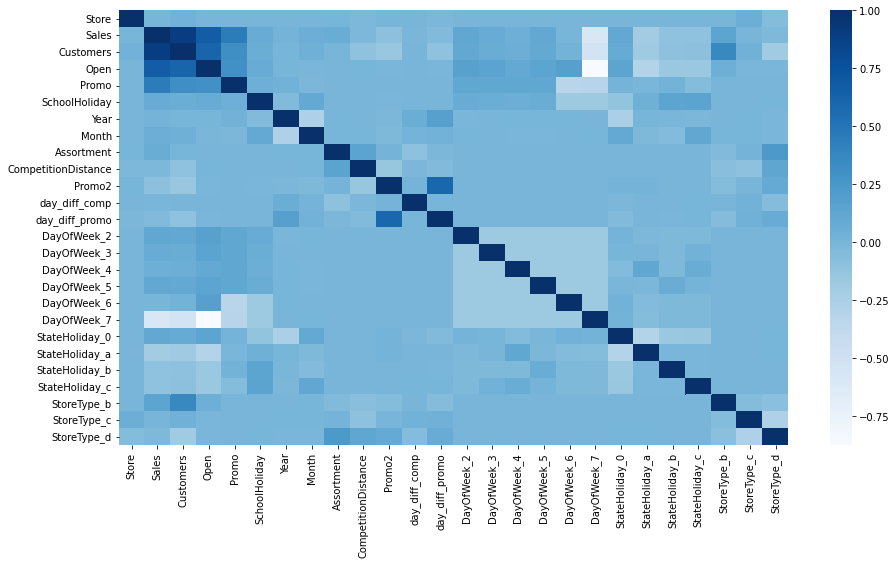

In [145]:
plt.figure(figsize=(15,8))
sns.heatmap(store_data_train.corr(),cmap="Blues")

In [146]:
import sklearn

In [147]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']